In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.beta import Beta
from torch.distributions.uniform import Uniform
from torch.distributions.relaxed_categorical import RelaxedOneHotCategorical as rcat

from torch import logsumexp
import sys
import time
import datetime
import math

In [2]:
Xs = torch.from_numpy(np.load('Shapes2.npy')).float()
Mus = torch.from_numpy(np.load('Mus2.npy')).float()
Xs = Xs.transpose(1,0)

N, D = Xs.shape
K = 4
## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 32
NUM_LATENTS = 2
NUM_OBS = D
NUM_EPOCHS = 25000
LEARNING_RATE = 1e-4
CUDA = False
PATH = 'circles'

In [3]:
class Encoder(nn.Module):
    def __init__(self, num_obs= NUM_OBS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_h = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh())
        self.enc_log_u_a = nn.Sequential(
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))
        self.enc_log_u_b = nn.Sequential(
            nn.Linear(num_hidden, int(0.5*num_hidden)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden), num_latents))

    def forward(self, obs, num_samples):
        h = self.enc_h(obs) # (B, H)
        a = torch.exp(self.enc_log_u_a(h)) # (B, 2)
        b = torch.exp(self.enc_log_u_b(h)) # (B, 2)
        q_u = Beta(a, b)
        u = q_u.sample((num_samples,)) # (S, B, 2)
        log_q_u = q_u.log_prob(u).sum(-1)
        return u, log_q_u
    
    
class Decoder(nn.Module):
    def __init__(self, num_obs=D,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()

        self.x_sigma = 0.01 * torch.ones(num_obs)
        self.dec_mu = nn.Sequential(
            nn.Linear(num_latents, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_obs))

    def forward(self, u, obs, num_samples):
        mu = self.dec_mu(u) # (S, B, K) -> (S, B, O)
        Nk = obs.shape[0]
        p_x = Normal(mu, self.x_sigma.repeat(num_samples, Nk, 1)) # (S, B, O)
        log_p_x = p_x.log_prob(obs).sum(-1) # (S, B)
        return mu, log_p_x

In [4]:
        
def initialize():
    enc_circle = Encoder()
    dec_circle = Decoder()
    
    enc_square = Encoder()
    dec_square = Decoder()
    
    enc_triangle = Encoder()
    dec_triangle = Decoder()
    
    enc_cross = Encoder()
    dec_cross = Decoder()
    return enc_circle, dec_circle, enc_square, dec_square, enc_triangle, dec_triangle, enc_cross, dec_cross
enc_circle, dec_circle, enc_square, dec_square, enc_triangle, dec_triangle, enc_cross, dec_cross = initialize()

In [5]:
enc_circle.load_state_dict(torch.load('VAE/enc-circle'))
enc_square.load_state_dict(torch.load('VAE/enc-square'))
enc_triangle.load_state_dict(torch.load('VAE/enc-triangle'))
enc_cross.load_state_dict(torch.load('VAE/enc-cross'))

dec_circle.load_state_dict(torch.load('VAE/dec-circle'))
dec_square.load_state_dict(torch.load('VAE/dec-square'))
dec_triangle.load_state_dict(torch.load('VAE/dec-triangle'))
dec_cross.load_state_dict(torch.load('VAE/dec-cross'))

In [6]:
def init_means():
    return Normal(torch.zeros((K, D)), torch.ones((K, D))).sample()
def E_step(X, mus, N, K, D):
    log_gammas = torch.zeros((K, N))
    for k in range(K):
        if k == 0:
            Xk = X - mus[k]
            u, log_q = enc_circle(Xk, 1)
            mu, log_p_x = dec_circle(u, Xk, 1)
            log_gammas[k] = log_p_x[0]
        elif k == 1:
            Xk = X - mus[k]
            u, log_q = enc_square(Xk, 1)
            mu, log_p_x = dec_square(u, Xk, 1)
            log_gammas[k] = log_p_x[0]
        elif k == 2:
            Xk = X - mus[k]
            u, log_q = enc_triangle(Xk, 1)
            mu, log_p_x = dec_triangle(u, Xk, 1)
            log_gammas[k] = log_p_x[0]
        else:
            Xk = X - mus[k]
            u, log_q = enc_cross(Xk, 1)
            mu, log_p_x = dec_cross(u, Xk, 1)
            log_gammas[k] = log_p_x[0]
    log_pis = log_gammas - logsumexp(log_gammas, 0)
    log_pis = log_pis.transpose(0,1)
    Z = rcat(temperature=torch.Tensor([0.066]), logits = log_pis).sample()
    return Z, log_pis

def M_type_step(X, mus, N, K, D):
    labels = Z.argmax(-1)
    mus = torch.zeros((K, D))
    for k in range(K):
        labels_k = labels == k
        if labels_k.sum().item() == 0:
            continue
        else:
            Xk = Xs[labels_k]
            
    log_gammas = torch.zeros((K, N))
    for k in range(K):
        if k == 0:
            Xk = X - mus[k]
            u, log_q = enc_circle(Xk, 1)
            mu, log_p_x = dec_circle(u, Xk, 1)
            log_gammas[k] = log_p_x[0]
        elif k == 1:
            Xk = X - mus[k]
            u, log_q = enc_square(Xk, 1)
            mu, log_p_x = dec_square(u, Xk, 1)
            log_gammas[k] = log_p_x[0]
        elif k == 2:
            Xk = X - mus[k]
            u, log_q = enc_triangle(Xk, 1)
            mu, log_p_x = dec_triangle(u, Xk, 1)
            log_gammas[k] = log_p_x[0]
        else:
            Xk = X - mus[k]
            u, log_q = enc_cross(Xk, 1)
            mu, log_p_x = dec_cross(u, Xk, 1)
            log_gammas[k] = log_p_x[0]
    log_pis = log_gammas - logsumexp(log_gammas, 0)
    log_pis = log_pis.transpose(0,1)
    Z = rcat(temperature=torch.Tensor([0.066]), logits = log_pis).sample()
    return Z, log_pis

def M_mean_step(X, Z, N, K, D):
    labels = Z.argmax(-1)
    mus = torch.zeros((K, D))
    for k in range(K):
        labels_k = labels == k
        if labels_k.sum().item() == 0:
            continue
        else:
            mus[k] = Xs[labels_k].mean(0)
    return mus 

In [35]:
mus = init_means()
for i in range(10):
    Z, log_pis = E_step(Xs, mus, N, K, D)
    mus = M_step(Xs, Z, N, K, D)

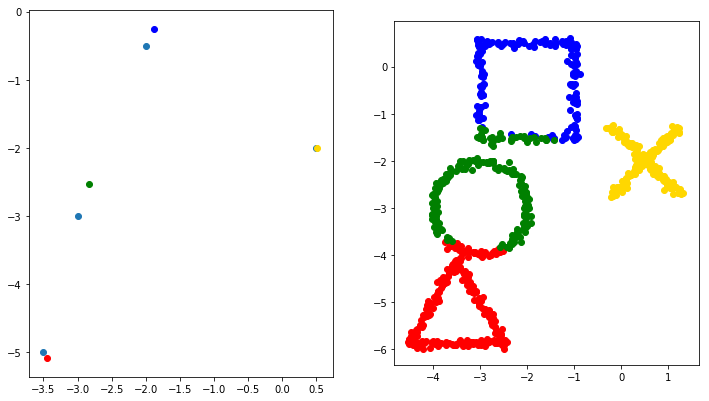

In [36]:
colors = ['red', 'blue', 'green', 'gold']
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.scatter(Mus[:, 0].data.numpy(), Mus[:, 1].data.numpy())

for k in range(K):  
    labels = Z.argmax(-1)
    labels_k = labels == k
    Xk = Xs[labels_k]
    ax1.scatter(mus[k, 0].data.numpy(), mus[k, 1].data.numpy(), c=colors[k])
    ax2.scatter(Xk[:,0].data.numpy(), Xk[:,1].data.numpy(), c=colors[k])
ax1.set_aspect('equal')
ax2.set_aspect('equal')

In [ ]:

mus = init_means()
Z, log_pis = E_step(Xs, mus, N, K, D)

labels = Z.argmax(-1)
mus = torch.zeros((K, D))
for k in range(K):
    labels_k = labels == k
    if labels_k.sum().item() == 0:
        continue
    else:
        mus[k] = Xs[labels_k].mean(0)

In [ ]:
mus

In [ ]:
labels = Z.argmax(-1)

In [ ]:
lk = labels == 2